In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read data file (csv)

df = pd.read_csv(r"C:\Users\hp\My Project\Project Cat Breeds v2 (Classification) (10 class)\data\cat_breeds_dataset.csv",delimiter=',')

df

,Breeds,Weight,length,Age,Sleep_hours,Fur_length_long,Fur_length_medium/long,Fur_length_short,Fur_length_short/medium,Fur_type_Thick/soft,...,Fur_color_smokey,Fur_color_white,Eye_color_Hazelnut,Eye_color_amber,Eye_color_blue,Eye_color_copper,Eye_color_golden,Eye_color_green,Eye_color_pink,Eye_color_two different eyes
0,7,0.226190,0.146667,0.636364,0.500000,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,7,0.107143,0.253333,0.727273,0.833333,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,7,0.273810,0.266667,0.272727,0.666667,1,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
3,8,0.023810,0.106667,0.454545,0.000000,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,4,0.642857,0.626667,0.272727,0.666667,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407,4,0.571429,0.853333,0.545455,0.500000,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1408,2,0.095238,0.106667,0.363636,0.666667,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1409,6,0.750000,0.333333,0.454545,0.333333,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1410,0,0.119048,0.093333,0.090909,0.166667,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [3]:
# Define the dataset class

class CatBreedDataset(Dataset):
  def __init__(self, Data , Labels):
    self.X = torch.tensor(Data, dtype=torch.float32)
    self.y = torch.tensor(Labels, dtype=torch.long)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

In [4]:
# Store features in X and labels in y
# Split data into training data and test data
# Define the datasets and dataloaders

X = np.array(df.iloc[:,1:])
y = np.array(df.iloc[:,0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

trianDataset = CatBreedDataset(X_train, y_train)
testDataset = CatBreedDataset(X_test, y_test)
valDataset = CatBreedDataset(X_val, y_val)

trainLoader = DataLoader(trianDataset, batch_size=32, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=32, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=32, shuffle=False)

In [5]:
# Define the model structure class

class CatClassifier(nn.Module):
  def __init__(self, INPUTS_SIZE, HIDDEN_SIZE_1 = 64, HIDDEN_SIZE_2 = 32, OUTPUTS_SIZE = 10):
    super(CatClassifier, self).__init__()
    self.input_layer = nn.Linear(INPUTS_SIZE, HIDDEN_SIZE_1)
    self.dropout = nn.Dropout(0.3)
    self.hidden_layer = nn.Linear(HIDDEN_SIZE_1, HIDDEN_SIZE_2)
    self.dropout = nn.Dropout(0.3)
    self.output_layer = nn.Linear(HIDDEN_SIZE_2, OUTPUTS_SIZE)

  def forward(self, x):
    x = F.relu(self.input_layer(x))
    x = self.dropout(x)
    x = F.relu(self.hidden_layer(x))
    x = self.dropout(x)
    x = self.output_layer(x)
    return x

In [6]:
# Create instance from the model
# Define the optimizer and loss function

input_size = X_train.shape[1]

model = CatClassifier(input_size)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Testing the model

def evaluate(model, dataloader, criterion):

  test_loss = 0.0
  correct = 0
  total = 0

  model.eval()
  with torch.no_grad():
    for inputs, targets in dataloader:
      outputs = model(inputs)

      loss = criterion(outputs, targets)
      test_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)

      total += targets.size(0)
      correct += (predicted == targets).sum().item()

  avg_loss = test_loss / len(dataloader)
  accuracy = 100 * (correct / total)
  

  return avg_loss, accuracy

In [8]:
# Training loop
# Validating the model

epochs = 50
train_losses = []
val_losses = []
all_preds = []
all_labels = []

for epoch in range(epochs):
  model.train()
  running_loss = 0.0

  for inputs, targets in trainLoader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  train_loss = running_loss / len(trainLoader)

  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for val_inputs, val_targets in valLoader:
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_targets)
      _, predicted = torch.max(val_outputs, 1)
      correct += (predicted == val_targets).sum().item()
      total += val_targets.size(0)

  val_accuracy = 100 * (correct / total)

  if epoch % 10 == 0:
    test_loss, test_accuracy = evaluate(model, testLoader, criterion)
    
  train_losses.append(loss.item())
  val_losses.append(val_loss.item())

  print(f"Epoch {epoch + 1}:- Train Loss: {train_loss}, Validation Loss: {val_loss}, Test Loss: {test_loss}, Validation Accuracy: {round(val_accuracy, 2)}, Test Accuracy: {round(test_accuracy, 2)}")

Epoch 1:- Train Loss: 2.2711975110901728, Validation Loss: 2.1747477054595947, Test Loss: 2.1742088317871096, Validation Accuracy: 41.73, Test Accuracy: 38.73
Epoch 2:- Train Loss: 2.0522944000032215, Validation Loss: 1.76791250705719, Test Loss: 2.1742088317871096, Validation Accuracy: 61.42, Test Accuracy: 38.73
Epoch 3:- Train Loss: 1.5661419464482202, Validation Loss: 1.0964851379394531, Test Loss: 2.1742088317871096, Validation Accuracy: 82.68, Test Accuracy: 38.73
Epoch 4:- Train Loss: 1.0503449274433985, Validation Loss: 0.6281741261482239, Test Loss: 2.1742088317871096, Validation Accuracy: 91.34, Test Accuracy: 38.73
Epoch 5:- Train Loss: 0.706894306672944, Validation Loss: 0.4100716710090637, Test Loss: 2.1742088317871096, Validation Accuracy: 96.06, Test Accuracy: 38.73
Epoch 6:- Train Loss: 0.5359548247522778, Validation Loss: 0.3183853328227997, Test Loss: 2.1742088317871096, Validation Accuracy: 96.85, Test Accuracy: 38.73
Epoch 7:- Train Loss: 0.4345811928311984, Validat

In [ ]:
#Collection of labels and predicted result.

all_labels = []
all_preds = []
model.eval()
with torch.no_grad():
    for inputs, targets in testLoader:
       outputs = model(inputs)
       _, predicted = torch.max(outputs.data, 1)

       all_preds.extend(predicted.cpu().numpy())
       all_labels.extend(targets.cpu().numpy())

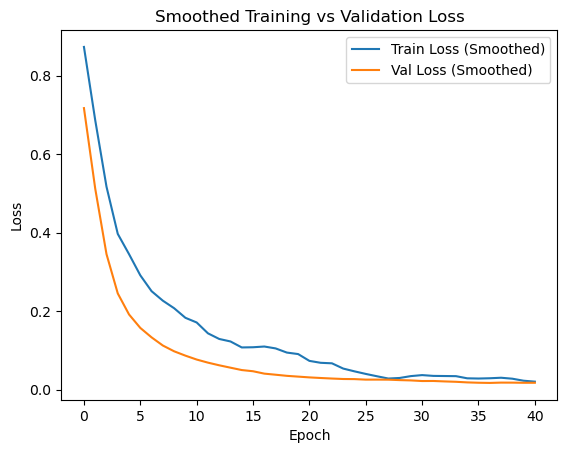

In [10]:
#Graph Training vs Validation Loss

def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.plot(moving_average(train_losses), label='Train Loss (Smoothed)')
plt.plot(moving_average(val_losses), label='Val Loss (Smoothed)')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Smoothed Training vs Validation Loss')
plt.show()

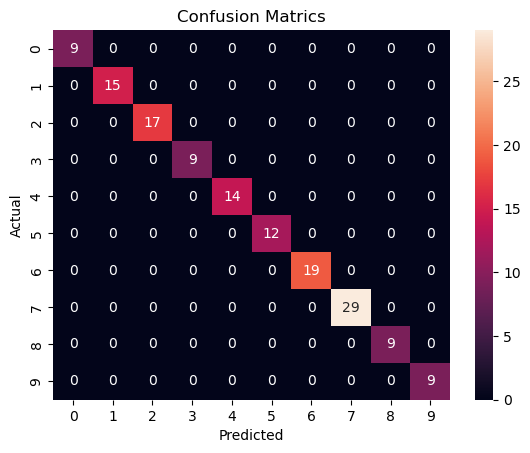

In [ ]:
#Calculation of the confusion matrix.

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True)
plt.title("Confusion Matrics")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
#Calculation of the classification report and accuracy score.

class_name = ['Abyssinian','British Shorthair','Egyption Mau', 'Japanese Bobtail', 'Maine Coon', 'Manx',
              'Norwegian Forest Cat', 'Persian', 'Siamese', 'Turkish Angora']

print(classification_report(all_labels, all_preds, target_names = class_name))

acc = accuracy_score(all_labels, all_preds)

print(f"Accuracy: {acc * 100}%")

                      precision    recall  f1-score   support

          Abyssinian       1.00      1.00      1.00         9
   British Shorthair       1.00      1.00      1.00        15
        Egyption Mau       1.00      1.00      1.00        17
    Japanese Bobtail       1.00      1.00      1.00         9
          Maine Coon       1.00      1.00      1.00        14
                Manx       1.00      1.00      1.00        12
Norwegian Forest Cat       1.00      1.00      1.00        19
             Persian       1.00      1.00      1.00        29
             Siamese       1.00      1.00      1.00         9
      Turkish Angora       1.00      1.00      1.00         9

            accuracy                           1.00       142
           macro avg       1.00      1.00      1.00       142
        weighted avg       1.00      1.00      1.00       142

Accuracy: 100.0%


In [ ]:
#Keep model weights

torch.save(model.state_dict(), "best_model.pt")